# MIOFlow data preparation

Prerequisites:
- You have preprocessed your adata using some time smoothing method into the data/preprocessed directory. [notebook: 3-time-pseudotime-meld]: 
    - gene values on _X_ (adata.X)
    - phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
    - phate visualization space of the data on _obsm_ (ex.: adata.obsm['X_phate_visualization])
    - any extra metadata on _obs_ (ex.: adata.obs['time_label'], adata.obs['disease_progression'], etc...)
    - smoothed time in the on _obsm_ (ex.: adata.obsm['smooth_time'])

- You have trained and saved a Dimension Changer Encoder/Decoder [notebook: 4-dimension-changer]:
    - saved under the `DIMENSION_CHANGER_DIR = '../../dimension_changer'`


In this notebook, we will:
- Prepare the data to run MIOFLOW on top of it

# TODO: BETTER DESCRIPTION OF THIS NOTEBOOK

In [80]:
import scanpy as sc
import os
import pandas as pd
import scprep

PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')
RESULTS_DIR = os.path.join('../../results')
os.makedirs(RESULTS_DIR, exist_ok=True)


data_name = 'adata'

SAVE_PATH = os.path.join(RESULTS_DIR, data_name)
os.makedirs(SAVE_PATH, exist_ok=True)

adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_time.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'

# We will now bin our time, to have a guidance to our MIOFlow to infer trajectories

In [81]:
adata.obs['bin_time'] = pd.cut(adata.obs['smooth_time'], bins=10, labels=False)
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time', 'bin_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'

#### Before we analyse the binned time, let's remeber how our initial PHATE looked.

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

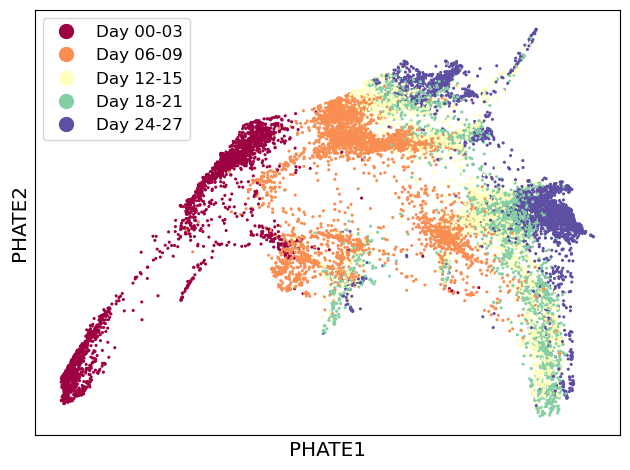

In [84]:
scprep.plot.scatter2d(adata.obsm['X_phate_visualization'], c=adata.obs['time_label'], cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

#### We then binned it to retrieve a meld scored over a smoothed time

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

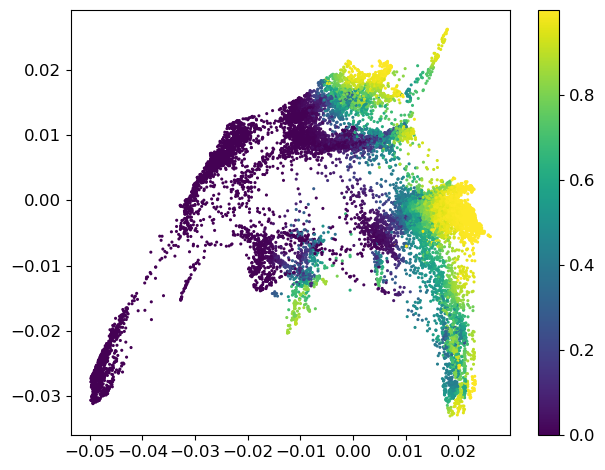

In [85]:
scprep.plot.scatter2d(adata.obsm['X_phate_visualization'], c=adata.obs['smooth_time'], cmap='viridis')

#### Here the binned time is just a way to discretized the continuous smooth time score

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


bin_time
2    4443
4    3910
5    3563
3    3494
1    2534
Name: count, dtype: int64


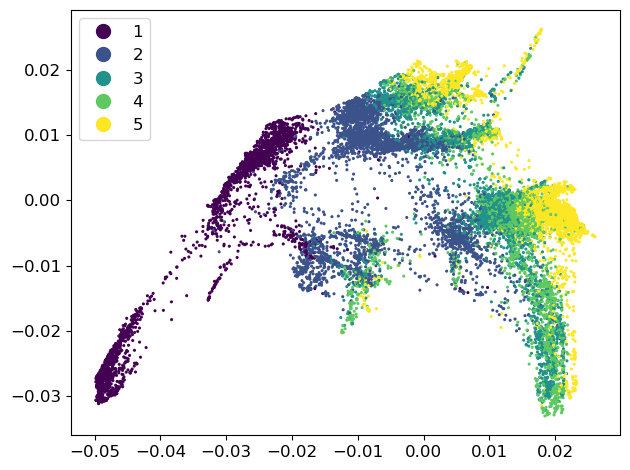

In [86]:
scprep.plot.scatter2d(adata.obsm['X_phate_visualization'], c=adata.obs['bin_time'], cmap='viridis')
print(adata.obs['bin_time'].value_counts())

## Finally, we create the MIOFlow DataFrame, that is saving for each datapoint what is it's label in a  discretized manner.

In [87]:
adata.obsm['X_phate'].shape

(17944, 10)

In [88]:
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=[f'd{i}' for i in range(1, adata.obsm['X_phate'].shape[1]+1)])
mioflow_df['samples'] = adata.obs['bin_time'].values
mioflow_df

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,samples
0,-0.032035,-0.006691,-0.000198,0.002757,0.001421,0.000440,0.001422,-0.000072,0.000476,-0.000022,1
1,-0.030641,-0.003389,0.004110,0.001582,0.002390,-0.000255,0.001286,0.001017,-0.000965,-0.000132,1
2,-0.022368,0.004742,0.000466,0.000421,0.004072,-0.000411,0.002846,0.001671,-0.000916,0.000001,1
3,-0.022434,0.005204,-0.000575,0.000055,0.003677,-0.000376,0.003045,0.001817,-0.001587,0.000090,1
4,-0.042244,-0.021911,-0.006090,0.004921,-0.002811,0.000925,0.000425,-0.001488,0.001227,0.000179,1
...,...,...,...,...,...,...,...,...,...,...,...
17939,0.014014,-0.000327,0.002445,0.001519,-0.001698,0.001073,0.001412,-0.000789,-0.000105,0.000096,5
17940,0.015794,-0.001963,0.001252,0.000803,-0.000996,0.001746,0.001530,-0.000598,-0.000247,-0.000260,5
17941,0.018862,-0.006424,-0.004108,-0.002603,-0.002563,0.000855,0.003072,-0.001645,-0.000434,0.000845,5
17942,0.019578,-0.008143,-0.006314,-0.002232,-0.003649,0.001721,0.003423,-0.001628,-0.000747,0.000992,5


### And we save the mioflow_df to the results as well as save a new version of our adata object

In [89]:
mioflow_df.to_csv(os.path.join(SAVE_PATH,'mioflow_data_10d.csv'), index=False)

adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata_mioflow.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time', 'bin_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'